# CS418 Final Project: Energy Usage
## Arpita Kumari, Kaveesha Weerasiri, Reem Hussein
Description: The problem we will be focusing on is to predict the total kWh in Chicago in 2010 for different communities. We want to see what communities have the highest total kWh in Chicago based on the total units.

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
import math

In [2]:
#importing the data set
energy_data = pd.read_csv("energy_usage.csv")
energy_data.head()

,COMMUNITY AREA NAME,CENSUS BLOCK,BUILDING TYPE,BUILDING_SUBTYPE,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,...,TOTAL POPULATION,TOTAL UNITS,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS
0,Archer Heights,1.703157e+14,Residential,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,89.0,24.0,2.0,71.33,3.87,23.0,0.9582,9.0,0.3910,23.0
1,Ashburn,1.703170e+14,Residential,Multi 7+,7334.0,7741.0,4214.0,4284.0,2518.0,4273.0,...,112.0,67.0,2.0,41.00,1.81,62.0,0.9254,50.0,0.8059,62.0
2,Auburn Gresham,1.703171e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,102.0,48.0,3.0,86.00,3.00,34.0,0.7082,23.0,0.6759,34.0
3,Austin,1.703125e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,121.0,56.0,2.0,84.00,2.95,41.0,0.7321,32.0,0.7800,41.0
4,Austin,1.703125e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,62.0,23.0,2.0,85.00,3.26,19.0,0.8261,11.0,0.5790,19.0


In [3]:
# identify what is considered high, medium, and low
# low is lower than 28223 (< 25%)
# medium is between 28223 and 118396.5 (25% <= x <= 75%)
# high is 118396.5 (> 75%)
energy_data['TOTAL KWH'].describe()

count    6.618000e+04
mean     2.375188e+05
std      4.294269e+06
min      1.020000e+02
25%      2.822300e+04
50%      6.234150e+04
75%      1.183965e+05
max      5.831747e+08
Name: TOTAL KWH, dtype: float64

In [4]:
# got help from https://www.delftstack.com/howto/python-pandas/how-to-create-dataframe-column-based-on-given-condition-in-pandas/
decideEnergyLabel = [
    (energy_data['TOTAL KWH'] < 28223) ,
    (energy_data['TOTAL KWH'] >= 28223) & (energy_data['TOTAL KWH'] < 118396.5),
    (energy_data['TOTAL KWH'] >= 118396.5)]
# 1 corresponds with low, 2 corresponds with medium, and 3 corresponds with high
# I have it in numbers because when you try to scale the data it gives an error expecting to see numbers, not strings
# I put None for default so that it would probably be removed when cleaning the data
energyLabel = [1, 2, 3]
energy_data['energy_label'] = np.select(decideEnergyLabel, energyLabel, default=0)
energy_data.head(10)

,COMMUNITY AREA NAME,CENSUS BLOCK,BUILDING TYPE,BUILDING_SUBTYPE,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,...,TOTAL UNITS,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS,energy_label
0,Archer Heights,1.703157e+14,Residential,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,24.0,2.0,71.33,3.87,23.0,0.9582,9.0,0.3910,23.0,0
1,Ashburn,1.703170e+14,Residential,Multi 7+,7334.0,7741.0,4214.0,4284.0,2518.0,4273.0,...,67.0,2.0,41.00,1.81,62.0,0.9254,50.0,0.8059,62.0,2
2,Auburn Gresham,1.703171e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,3.0,86.00,3.00,34.0,0.7082,23.0,0.6759,34.0,0
3,Austin,1.703125e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,56.0,2.0,84.00,2.95,41.0,0.7321,32.0,0.7800,41.0,0
4,Austin,1.703125e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,2.0,85.00,3.26,19.0,0.8261,11.0,0.5790,19.0,0
5,Austin,1.703125e+14,Commercial,Commercial,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,2.0,131.00,3.00,18.0,1.0000,10.0,0.5560,18.0,1
6,Austin,1.703125e+14,Commercial,Commercial,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,54.00,0.00,0.0,NaN,0.0,NaN,0.0,0
7,Austin,1.703125e+14,Commercial,Multi < 7,1470.0,1325.0,294.0,391.0,366.0,2204.0,...,63.0,2.0,131.00,1.02,59.0,0.9365,59.0,1.0000,59.0,1
8,Austin,1.703125e+14,Residential,Multi 7+,2461.0,4888.0,2893.0,2737.0,2350.0,3037.0,...,31.0,3.0,99.00,2.93,27.0,0.8710,27.0,1.0000,27.0,2
9,Austin,1.703125e+14,Residential,Multi 7+,0.0,0.0,0.0,0.0,0.0,511.0,...,33.0,3.0,99.00,3.82,22.0,0.6667,16.0,0.7270,22.0,1


In [5]:
energy_data.describe()

,CENSUS BLOCK,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,KWH JULY 2010,KWH AUGUST 2010,KWH SEPTEMBER 2010,...,TOTAL UNITS,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS,energy_label
count,6.697400e+04,6.618000e+04,6.618000e+04,6.618000e+04,6.618000e+04,6.618000e+04,6.618000e+04,6.618000e+04,6.618000e+04,6.618000e+04,...,67037.000000,67051.000000,67051.000000,67037.000000,67037.000000,64606.000000,67037.000000,64433.000000,67037.000000,67051.000000
mean,1.703140e+14,1.758159e+04,1.737651e+04,1.624212e+04,1.595696e+04,1.906623e+04,2.300485e+04,2.482891e+04,2.267526e+04,1.856410e+04,...,48.375897,1.887592,71.593006,3.454721,42.347495,0.880365,25.438952,0.511679,42.347495,1.974035
std,2.776392e+09,3.482508e+05,3.351910e+05,3.164713e+05,3.118232e+05,3.634429e+05,3.988582e+05,4.135955e+05,3.940989e+05,3.486212e+05,...,426.941305,1.957215,34.168384,26.146208,371.024953,0.130937,251.193571,0.288431,371.024953,0.738095
min,1.703101e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.703116e+14,1.370000e+03,1.613000e+03,1.586000e+03,1.579000e+03,1.957000e+03,2.700000e+03,3.203000e+03,2.837750e+03,2.027000e+03,...,15.000000,1.140000,53.000000,2.150000,13.000000,0.833200,3.000000,0.286000,13.000000,1.000000
50%,1.703133e+14,3.481500e+03,3.814000e+03,3.681500e+03,3.646000e+03,4.528000e+03,6.295000e+03,7.389000e+03,6.413500e+03,4.573000e+03,...,25.000000,1.750000,80.000000,2.700000,22.000000,0.914600,11.000000,0.537900,22.000000,2.000000
75%,1.703167e+14,7.157000e+03,7.410250e+03,7.059000e+03,7.010000e+03,8.943500e+03,1.282850e+04,1.465750e+04,1.229800e+04,8.634000e+03,...,42.000000,2.000000,96.500000,3.320000,37.000000,0.967700,23.000000,0.733000,37.000000,2.000000
max,1.703198e+14,5.298534e+07,4.787976e+07,4.413646e+07,4.222055e+07,4.861925e+07,5.256908e+07,5.513983e+07,5.158912e+07,4.450386e+07,...,51372.000000,110.000000,158.000000,2061.920000,43222.000000,1.000000,28335.000000,1.000000,43222.000000,3.000000


In [6]:
energy_data.dtypes

COMMUNITY AREA NAME                    object
CENSUS BLOCK                          float64
BUILDING TYPE                          object
BUILDING_SUBTYPE                       object
KWH JANUARY 2010                      float64
                                       ...   
OCCUPIED UNITS PERCENTAGE             float64
RENTER-OCCUPIED HOUSING UNITS         float64
RENTER-OCCUPIED HOUSING PERCENTAGE    float64
OCCUPIED HOUSING UNITS                float64
energy_label                            int64
Length: 74, dtype: object

In [7]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67051 entries, 0 to 67050
Data columns (total 74 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   COMMUNITY AREA NAME                  67051 non-null  object 
 1   CENSUS BLOCK                         66974 non-null  float64
 2   BUILDING TYPE                        66974 non-null  object 
 3   BUILDING_SUBTYPE                     66974 non-null  object 
 4   KWH JANUARY 2010                     66180 non-null  float64
 5   KWH FEBRUARY 2010                    66180 non-null  float64
 6   KWH MARCH 2010                       66180 non-null  float64
 7   KWH APRIL 2010                       66180 non-null  float64
 8   KWH MAY 2010                         66180 non-null  float64
 9   KWH JUNE 2010                        66180 non-null  float64
 10  KWH JULY 2010                        66180 non-null  float64
 11  KWH AUGUST 2010             

In [8]:
print('Number of missing values per column:')
missing_values = energy_data.isin([0]).sum()
missing_values[0:36]

Number of missing values per column:


COMMUNITY AREA NAME         0
CENSUS BLOCK                0
BUILDING TYPE               0
BUILDING_SUBTYPE            0
KWH JANUARY 2010         3069
KWH FEBRUARY 2010        1359
KWH MARCH 2010           1036
KWH APRIL 2010            865
KWH MAY 2010              683
KWH JUNE 2010             542
KWH JULY 2010             427
KWH AUGUST 2010           314
KWH SEPTEMBER 2010        206
KWH OCTOBER 2010          108
KWH NOVEMBER 2010          50
KWH DECEMBER 2010          41
TOTAL KWH                   0
ELECTRICITY ACCOUNTS        0
ZERO KWH ACCOUNTS       14965
THERM JANUARY 2010          0
THERM FEBRUARY 2010         0
THERM MARCH 2010            0
TERM APRIL 2010             0
THERM MAY 2010              0
THERM JUNE 2010             0
THERM JULY 2010             0
THERM AUGUST 2010           0
THERM SEPTEMBER 2010        0
THERM OCTOBER 2010          0
THERM NOVEMBER 2010         0
THERM DECEMBER 2010         0
TOTAL THERMS                0
GAS ACCOUNTS                0
KWH TOTAL 

In [9]:
missing_values[36:73]

KWH STANDARD DEVIATION 2010              12
KWH MINIMUM 2010                          0
KWH 1ST QUARTILE 2010                     0
KWH 2ND QUARTILE 2010                     0
KWH 3RD QUARTILE 2010                     0
KWH MAXIMUM 2010                          0
KWH SQFT MEAN 2010                        0
KWH SQFT STANDARD DEVIATION 2010        866
KWH SQFT MINIMUM 2010                     0
KWH SQFT 1ST QUARTILE 2010                0
KWH SQFT 2ND QUARTILE 2010                0
KWH SQFT 3RD QUARTILE 2010                0
KWH SQFT MAXIMUM 2010                     0
THERM MEAN 2010                           0
THERM STANDARD DEVIATION 2010            18
THERM MINIMUM 2010                        0
THERM 1ST QUARTILE 2010                   0
THERM 2ND QUARTILE 2010                   0
THERM 3RD QUARTILE 2010                   0
THERM MAXIMUM 2010                        0
THERMS SQFT MEAN 2010                     0
THERMS SQFT STANDARD DEVIATION 2010     883
THERMS SQFT MINIMUM 2010        

## There are missing values for the following columns

KWH JANUARY 2010                      3069

KWH FEBRUARY 2010                     1359

KWH MARCH 2010                        1036

KWH APRIL 2010                         865

KWH MAY 2010                           683

KWH JUNE 2010                          542

KWH JULY 2010                          427

KWH AUGUST 2010                        314

KWH SEPTEMBER 2010                     206

KWH OCTOBER 2010                       108

KWH NOVEMBER 2010                       50

KWH DECEMBER 2010                       41

ZERO KWH ACCOUNTS                    14965

KWH STANDARD DEVIATION 2010             12

KWH SQFT STANDARD DEVIATION 2010       866

THERM STANDARD DEVIATION 2010           18

THERMS SQFT STANDARD DEVIATION 2010    883

TOTAL POPULATION                      2525

TOTAL UNITS                           2431

AVERAGE BUILDING AGE                  5309

AVERAGE HOUSESIZE                     2604

OCCUPIED UNITS                        2604

OCCUPIED UNITS PERCENTAGE              173

RENTER-OCCUPIED HOUSING UNITS         6726

RENTER-OCCUPIED HOUSING PERCENTAGE    4122

OCCUPIED HOUSING UNITS                2604

'ZERO KWH ACCOUNTS' variable should be removed from the data set, because more than a fifth of the values are missing. We can't remove the observations since there are so many missing, so we should just remove the variable to work with the information. We removed the rest of the observations that had NA as a value.

In [10]:
energy_data = energy_data.drop('ZERO KWH ACCOUNTS',  axis=1)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
energy_data = energy_data.dropna()

In [11]:
print("Summary statistics for all numerical features")
energy_data.describe(include=['number'])

Summary statistics for all numerical features


,CENSUS BLOCK,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,KWH JULY 2010,KWH AUGUST 2010,KWH SEPTEMBER 2010,...,TOTAL UNITS,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS,energy_label
count,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,...,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000
mean,1.703141e+14,9.029018e+03,9.071388e+03,8.538137e+03,8.404627e+03,1.055940e+04,1.410426e+04,1.579704e+04,1.370600e+04,1.023804e+04,...,37.660579,1.727001,75.073613,2.901079,33.262510,0.888389,18.719968,0.471502,33.262510,2.165613
std,2.734253e+09,7.379044e+04,6.762500e+04,5.733466e+04,5.567833e+04,6.564409e+04,7.410903e+04,9.261221e+04,8.237442e+04,6.578083e+04,...,54.831089,1.135246,28.259171,0.837439,48.591219,0.116450,36.283273,0.285204,48.591219,0.631202
min,1.703101e+14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.043500,0.000000,0.000000,1.000000,1.000000
25%,1.703116e+14,2.186000e+03,2.524000e+03,2.459000e+03,2.432000e+03,3.008000e+03,4.191000e+03,4.946000e+03,4.288000e+03,3.045000e+03,...,16.000000,1.180000,57.500000,2.300000,14.000000,0.842100,3.000000,0.231000,14.000000,2.000000
50%,1.703141e+14,4.442000e+03,4.844500e+03,4.680500e+03,4.635000e+03,5.801000e+03,8.209000e+03,9.559000e+03,8.091000e+03,5.730500e+03,...,25.000000,1.650000,79.630000,2.820000,22.000000,0.917400,10.000000,0.500000,22.000000,2.000000
75%,1.703166e+14,7.833000e+03,8.075250e+03,7.682250e+03,7.631250e+03,9.813250e+03,1.429600e+04,1.627500e+04,1.353750e+04,9.433250e+03,...,41.000000,2.000000,95.330000,3.410000,36.000000,0.971400,21.000000,0.692000,36.000000,3.000000
max,1.703184e+14,1.013538e+07,9.513220e+06,7.169960e+06,7.137167e+06,8.842112e+06,1.042817e+07,1.525210e+07,1.315616e+07,9.322770e+06,...,1365.000000,50.500000,153.500000,12.000000,1034.000000,1.000000,993.000000,1.000000,1034.000000,3.000000


In [12]:
print("Summary statistics for all categorical features")
energy_data.describe(exclude=['number'])

Summary statistics for all categorical features


,COMMUNITY AREA NAME,BUILDING TYPE,BUILDING_SUBTYPE,ELECTRICITY ACCOUNTS,GAS ACCOUNTS
count,45884,45884,45884,45884,45884
unique,77,3,6,273,150
top,Austin,Residential,Single Family,Less than 4,Less than 4
freq,1895,39975,23449,3936,4424


In [13]:
print("Summary statistics for all categorical features")
energy_data.describe(include='all')

Summary statistics for all categorical features


,COMMUNITY AREA NAME,CENSUS BLOCK,BUILDING TYPE,BUILDING_SUBTYPE,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,...,TOTAL UNITS,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS,energy_label
count,45884,4.588400e+04,45884,45884,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,4.588400e+04,...,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000,45884.000000
unique,77,NaN,3,6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Austin,NaN,Residential,Single Family,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1895,NaN,39975,23449,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.703141e+14,NaN,NaN,9.029018e+03,9.071388e+03,8.538137e+03,8.404627e+03,1.055940e+04,1.410426e+04,...,37.660579,1.727001,75.073613,2.901079,33.262510,0.888389,18.719968,0.471502,33.262510,2.165613
std,NaN,2.734253e+09,NaN,NaN,7.379044e+04,6.762500e+04,5.733466e+04,5.567833e+04,6.564409e+04,7.410903e+04,...,54.831089,1.135246,28.259171,0.837439,48.591219,0.116450,36.283273,0.285204,48.591219,0.631202
min,NaN,1.703101e+14,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.043500,0.000000,0.000000,1.000000,1.000000
25%,NaN,1.703116e+14,NaN,NaN,2.186000e+03,2.524000e+03,2.459000e+03,2.432000e+03,3.008000e+03,4.191000e+03,...,16.000000,1.180000,57.500000,2.300000,14.000000,0.842100,3.000000,0.231000,14.000000,2.000000
50%,NaN,1.703141e+14,NaN,NaN,4.442000e+03,4.844500e+03,4.680500e+03,4.635000e+03,5.801000e+03,8.209000e+03,...,25.000000,1.650000,79.630000,2.820000,22.000000,0.917400,10.000000,0.500000,22.000000,2.000000
75%,NaN,1.703166e+14,NaN,NaN,7.833000e+03,8.075250e+03,7.682250e+03,7.631250e+03,9.813250e+03,1.429600e+04,...,41.000000,2.000000,95.330000,3.410000,36.000000,0.971400,21.000000,0.692000,36.000000,3.000000


[Text(0, 0.5, 'count'),
 Text(0.5, 0, 'building type'),
 Text(0.5, 1.0, 'Number of each type of building')]

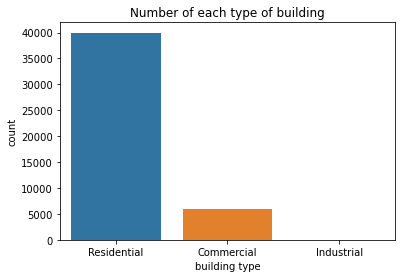

In [14]:
ax = sns.countplot(x = "BUILDING TYPE", data = energy_data)
ax.set(title = 'Number of each type of building', xlabel = 'building type', ylabel = 'count')

[Text(0, 0.5, 'Total kWh'),
 Text(0.5, 0, 'Building Type'),
 Text(0.5, 1.0, 'Total kWh by Building Type')]

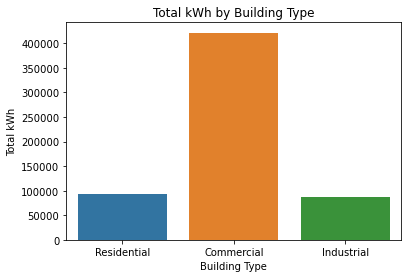

In [15]:
# Plot vertical bar chart with counts
ax = sns.barplot(x = energy_data['BUILDING TYPE'], y = energy_data['TOTAL KWH'], data = energy_data, ci = None)
ax.set(title = 'Total kWh by Building Type', xlabel = 'Building Type', ylabel = 'Total kWh')

[Text(0, 0.5, 'Total kWh'),
 Text(0.5, 0, 'Community Area name'),
 Text(0.5, 1.0, 'Total kWh by Community Area')]

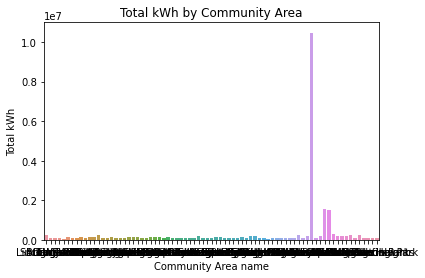

In [16]:
# Plot vertical bar chart with counts
ax = sns.barplot(x = energy_data['COMMUNITY AREA NAME'], y = energy_data['TOTAL KWH'], data = energy_data, ci = None)

ax.set(title = 'Total kWh by Community Area', xlabel = 'Community Area name', ylabel = 'Total kWh')

In [17]:
# translate the types of buildings to numbers
# Residential = 0
# Commerical = 1
# Industrial = 2

energy_altered_data = energy_data
type_buildings = ['Residential', 'Commercial', 'Industrial']
building_mappings = {'Residential' : 0, 'Commercial' : 1, 'Industrial' : 2}

energy_altered_data['BUILDING TYPE'] = energy_altered_data['BUILDING TYPE'].map(building_mappings)

(-1.1054445963106327,
 1.100259266496139,
 -1.1064460126782123,
 1.106773672785429)

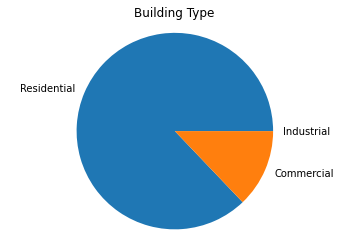

In [18]:
# create the pie chart 
num_residential = len(energy_altered_data[energy_altered_data['BUILDING TYPE'] == 0])
num_commerical = len(energy_altered_data[energy_altered_data['BUILDING TYPE'] == 1])
num_industrial = len(energy_altered_data[energy_altered_data['BUILDING TYPE'] == 2])
total_buildings= len(energy_altered_data['BUILDING TYPE'])

# compute the size of each type of building

sizes = [num_residential/total_buildings, num_commerical/total_buildings, num_industrial/total_buildings]
#energy_altered_data.head()
plt.pie(sizes, labels = type_buildings, explode = None)
plt.title('Building Type')
plt.axis('equal')

## Creating dummy variables for linear regression

In [19]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
energy_data['BUILDING TYPE'] = pd.get_dummies(energy_data['BUILDING TYPE'])
energy_data['BUILDING_SUBTYPE'] = pd.get_dummies(energy_data['BUILDING_SUBTYPE'])
energy_data['ELECTRICITY ACCOUNTS'] = pd.get_dummies(energy_data['ELECTRICITY ACCOUNTS'])
energy_data['GAS ACCOUNTS'] = pd.get_dummies(energy_data['GAS ACCOUNTS'])
energy_data['COMMUNITY AREA NAME'] = pd.get_dummies(energy_data['COMMUNITY AREA NAME'])

## Set Up For Linear Regression

In [20]:
energy_data['kwh_or_therms'] = np.where(energy_data['TOTAL KWH'] > energy_data['TOTAL THERMS'], 1, 0)
energy_data.head(10)

,COMMUNITY AREA NAME,CENSUS BLOCK,BUILDING TYPE,BUILDING_SUBTYPE,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,...,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS,energy_label,kwh_or_therms
103,0,1.703107e+14,1,0,242.0,136.0,134.0,134.0,144.0,122.0,...,4.00,12.00,2.77,22.0,1.0000,11.0,0.500,22.0,1,1
201,0,1.703143e+14,1,0,1266.0,1023.0,897.0,772.0,826.0,1095.0,...,2.50,114.50,1.62,138.0,0.8679,106.0,0.768,138.0,1,1
259,1,1.703114e+14,1,0,11921.0,12145.0,9759.0,11542.0,14348.0,26617.0,...,3.00,65.50,2.20,60.0,0.9375,33.0,0.550,60.0,3,1
279,0,1.703158e+14,1,0,3271.0,2117.0,1520.0,3073.0,3350.0,5737.0,...,2.00,84.00,5.00,19.0,0.8636,4.0,0.211,19.0,2,1
297,0,1.703168e+14,1,0,399.0,878.0,819.0,962.0,2414.0,1759.0,...,2.00,108.00,4.21,14.0,0.6364,8.0,0.571,14.0,1,1
307,0,1.703156e+14,0,0,1937.0,2573.0,1871.0,2138.0,2148.0,3445.0,...,1.33,18.33,2.00,1.0,0.3333,0.0,0.000,1.0,2,1
355,0,1.703183e+14,1,0,1852.0,2186.0,1506.0,2238.0,1907.0,2122.0,...,2.00,110.00,2.33,9.0,1.0000,6.0,0.667,9.0,1,1
434,0,1.703153e+14,1,0,0.0,973.0,1207.0,873.0,985.0,1322.0,...,2.00,85.00,3.29,14.0,1.0000,8.0,0.571,14.0,1,1
465,1,1.703114e+14,1,0,12977.0,14639.0,12718.0,14973.0,16384.0,32940.0,...,2.50,87.69,3.51,65.0,0.8228,49.0,0.754,65.0,3,1
468,1,1.703114e+14,1,0,4985.0,2636.0,2353.0,4761.0,4391.0,7362.0,...,2.20,87.00,3.73,62.0,0.8856,49.0,0.790,62.0,2,1


In [21]:
predictor_variables = energy_data.drop(['KWH JANUARY 2010', 'KWH FEBRUARY 2010', 'KWH MARCH 2010', 'KWH APRIL 2010', 'KWH MAY 2010', 'KWH JUNE 2010', 'KWH JULY 2010', 'KWH AUGUST 2010', 'KWH SEPTEMBER 2010', 'KWH OCTOBER 2010', 'KWH NOVEMBER 2010', 'KWH DECEMBER 2010', 'THERM JANUARY 2010', 'THERM FEBRUARY 2010', 'THERM MARCH 2010', 'TERM APRIL 2010', 'THERM MAY 2010', 'THERM JUNE 2010', 'THERM JULY 2010', 'THERM AUGUST 2010', 'THERM SEPTEMBER 2010', 'THERM OCTOBER 2010', 'THERM NOVEMBER 2010', 'THERM DECEMBER 2010'],  axis=1)
x_train_comp, x_validation_comp, y_train, y_validation = train_test_split(predictor_variables, energy_data['energy_label'], test_size = 0.25, random_state = 0)

In [22]:
# Selecting variables for x_train
# x_train = x_train_comp.select_dtypes(include=[np.int64,np.float64])

# # Selecting required variables for x_validation
# x_validation = x_validation_comp.select_dtypes(include=[np.int64,np.float64])
# print(x_validation)

# # Standardizing the data
scaler = StandardScaler()
scaler.fit(x_train_comp)
x_train_scaled = scaler.transform(x_train_comp)
x_validation_scaled = scaler.transform(x_validation_comp)
x_train_scaled_df = pd.DataFrame(x_train_scaled,index = x_train_comp.index,columns=x_train_comp.columns)
x_validation_scaled_df = pd.DataFrame(x_validation_scaled,index = x_validation_comp.index,columns=x_validation_comp.columns)

## Total kWh model

In [23]:
print("total kwh coefficient: \n")
model = linear_model.LinearRegression()
fitted_model_kwh = model.fit(X = x_train_scaled_df, y = x_train_comp['TOTAL KWH'])
print(fitted_model_kwh.coef_)
print("\n")

y_predicted = fitted_model_kwh.predict(x_validation_scaled_df)
#calculation metrics
n = len(x_validation_scaled_df.index)
p = len(x_train_scaled_df.columns)
print(n)
print(p)
print(n-p-1)

#displaying the r squared for democraticTOTAL KWH
corr_coef = np.corrcoef(y_predicted,x_validation_comp['TOTAL KWH'])[1, 0]

R_squared = corr_coef ** 2
print("Coefficent of Determination:",R_squared)

adjusted_r = 1 - (((1-R_squared)*(n-1))/(n-p-1))
print("Adjusted Coefficent of Determination:",adjusted_r)

rmse = math.sqrt(mean_squared_error(y_predicted, x_validation_comp['TOTAL KWH']))
print('RMSE -',rmse)

#this is our best total kwh model!

total kwh coefficient: 

[ 9.39959104e-11 -1.01863407e-10 -3.05590220e-10 -4.07453626e-10
  6.38675652e+05  1.05501385e-10 -9.45874490e-11 -1.01863407e-10
  5.96628524e-10 -4.80213203e-10 -3.20142135e-10  7.56699592e-10
 -1.17870513e-09  1.49157131e-09 -4.43833414e-10 -7.27595761e-10
  3.63797881e-10  1.24236976e-09 -2.40106601e-10 -4.00177669e-11
 -1.21872290e-10 -7.93079380e-10 -2.36468622e-10 -8.13088263e-10
 -7.13043846e-10 -9.74978320e-10 -2.61934474e-10  1.30967237e-10
  3.63797881e-10  8.73114914e-11  9.74978320e-10 -1.50976120e-10
 -8.94942787e-10 -1.23691279e-10 -4.25643520e-10  4.54747351e-10
  5.23868948e-10  7.33052730e-10 -4.07453626e-10  1.52795110e-10
  2.21916707e-10 -8.54925020e-11  5.82076609e-11 -1.81898940e-10
  8.73114914e-11  7.27595761e-11 -2.03726813e-10  0.00000000e+00
 -1.16415322e-10 -2.18278728e-11]


11471
50
11420
Coefficent of Determination: 1.0
Adjusted Coefficent of Determination: 1.0
RMSE - 2.0566455551461873e-09


## Total Therms model

In [24]:
print("total therms coefficient: \n")
model = linear_model.LinearRegression()
fitted_model_kwh = model.fit(X = x_train_scaled_df, y = x_train_comp['TOTAL THERMS'])
print(fitted_model_kwh.coef_)
print("\n")

y_predicted = fitted_model_kwh.predict(x_validation_scaled_df)
#calculation metrics
n = len(x_validation_scaled_df.index)
p = len(x_train_scaled_df.columns)
print(n)
print(p)
print(n-p-1)

#displaying the r squared for democratic
corr_coef = np.corrcoef(y_predicted,x_validation_comp['TOTAL THERMS'])[1, 0]

R_squared = corr_coef ** 2
print("Coefficent of Determination:",R_squared)

adjusted_r = 1 - (((1-R_squared)*(n-1))/(n-p-1))
print("Adjusted Coefficent of Determination:",adjusted_r)

rmse = math.sqrt(mean_squared_error(y_predicted, x_validation_comp['TOTAL THERMS']))
print('RMSE -',rmse)

#this is our best total therms model!

total therms coefficient: 

[ 0.00000000e+00  7.24753590e-13  8.64019967e-12  1.81898940e-12
 -7.45785655e-11  7.27595761e-12  3.81565501e+04 -5.45696821e-12
  7.27595761e-12 -4.77484718e-12  2.52839527e-10 -1.57797331e-10
 -4.27462510e-11  6.36646291e-12 -7.45785655e-11  2.18278728e-11
  4.45652404e-11  1.74622983e-10 -1.20053301e-10 -4.91127139e-11
  1.81898940e-12 -3.50155460e-11 -2.27373675e-11  1.95541361e-11
 -5.00222086e-11 -4.36557457e-11 -3.72892828e-11  5.86624083e-11
  3.63797881e-12  1.09139364e-11  2.91038305e-11 -2.72848411e-12
 -6.36646291e-12  5.91171556e-11 -4.63842298e-11  1.59161573e-11
 -1.36424205e-11  2.41016096e-11  3.63797881e-12  9.09494702e-12
  2.34194886e-11  9.09494702e-12  7.27595761e-12 -8.18545232e-12
  1.81898940e-12  6.36646291e-12 -1.18234311e-11  1.81898940e-12
 -2.72848411e-11  9.09494702e-13]


11471
50
11420
Coefficent of Determination: 1.0
Adjusted Coefficent of Determination: 1.0
RMSE - 1.0091998052875418e-10


### Model with 'TOTAL POPULATION', 'ELECTRICITY ACCOUNTS', 'BUILDING_SUBTYPE', 'BUILDING TYPE' as predictors

In [25]:
model = linear_model.LinearRegression()                

classifier_kwh_or_therm = model.fit(X = x_train_scaled_df[['TOTAL POPULATION', 'ELECTRICITY ACCOUNTS', 'BUILDING_SUBTYPE', 'BUILDING TYPE']], y = x_train_comp['TOTAL KWH'])
print(classifier_kwh_or_therm.coef_)
y_predicted = classifier_kwh_or_therm.predict(x_validation_scaled_df[['TOTAL POPULATION', 'ELECTRICITY ACCOUNTS', 'BUILDING_SUBTYPE', 'BUILDING TYPE']])

n = len(x_validation_scaled_df.index)
p = len(x_train_scaled_df[['TOTAL POPULATION', 'ELECTRICITY ACCOUNTS', 'BUILDING_SUBTYPE', 'BUILDING TYPE']].columns)
n-p-1
print(n)
print(p)
print(n-p-1)

print("predicting kwh_or_therms:")
corr_coef = np.corrcoef(y_predicted,x_validation_comp['TOTAL KWH'])[1, 0]
R_squared = corr_coef ** 2
print("Coefficent of Determination:", R_squared)

adjusted_r = 1 - (((1-R_squared)*(n-1))/(n-p-1))
print("Adjusted Coefficent of Determination:",adjusted_r)

rmse = math.sqrt(mean_squared_error(y_predicted, x_validation_comp['TOTAL KWH']))
print('RMSE: ',rmse)

[163920.15177819  -1729.70932896  99706.80500699  -1830.29191143]
11471
4
11466
predicting kwh_or_therms:
Coefficent of Determination: 0.04351024197806143
Adjusted Coefficent of Determination: 0.04317656336022713
RMSE:  1223795.4632503402


### CLASSIFIER: k-Nearest Neighbors

In [26]:
classifier = KNeighborsClassifier(n_neighbors = 3)  
classifier.fit(x_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [27]:
# Predict class labels using k-nearest neighbors classifier
# euclidian predictor
y_pred = classifier.predict(x_validation_scaled) 

In [28]:
# Compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_validation, y_pred)
print("Confusion matrix using k-nearest neighbors:\n")
print(conf_matrix)

Confusion matrix using k-nearest neighbors:

[[1427   35    0]
 [   4 6630   17]
 [   0   37 3321]]


Confusion matrix using k-nearest neighbors:



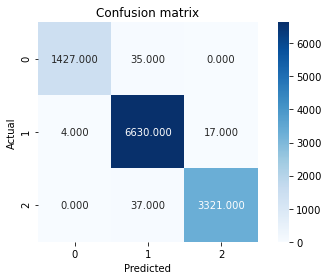

In [29]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
print("Confusion matrix using k-nearest neighbors:\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()

In [30]:
# Compute evaluation metrics
print("accuracy: " + str(metrics.accuracy_score(y_validation, y_pred))) # accuracy
print("error: " + str(1 - metrics.accuracy_score(y_validation, y_pred))) # error
print("precision: "+ str(metrics.precision_score(y_validation, y_pred, average = None))) # precision
print("recall: " + str(metrics.recall_score(y_validation, y_pred, average = None))) # recall
print("F1 score: " + str(metrics.f1_score(y_validation, y_pred, average = None))) # F1 score

accuracy: 0.9918925987272251
error: 0.008107401272774872
precision: [0.99720475 0.98925694 0.99490713]
recall: [0.97606019 0.99684258 0.98898154]
F1 score: [0.98651918 0.99303527 0.99193548]


In [31]:
# #loading the dataset
# energy_data = pd.read_csv('energy_usage.csv')
# energy_data.head()

In [32]:
x_test = energy_data.select_dtypes(include=[np.int64,np.float64])
x_test = x_test.iloc[:, :50].values
x_test_scaled = scaler.transform(x_test)
x_test_scaled_df = pd.DataFrame(x_test_scaled)

final_data = energy_data.iloc[:, [2,16]]
final_data.head()

predictedBuildings = fitted_model_kwh.predict(X = x_test_scaled)
predictedBuildings.shape
final_data.insert(2, 'PREDICTION', predictedBuildings)
final_data.head()

,BUILDING TYPE,TOTAL KWH,PREDICTION
103,1,15665.0,122.000000
201,1,13484.0,1095.000000
259,1,201032.0,26617.000001
279,1,42952.0,5737.000000
297,1,22978.0,1759.000000
